# Multiple Linear regression

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)
sns.set()

In [4]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

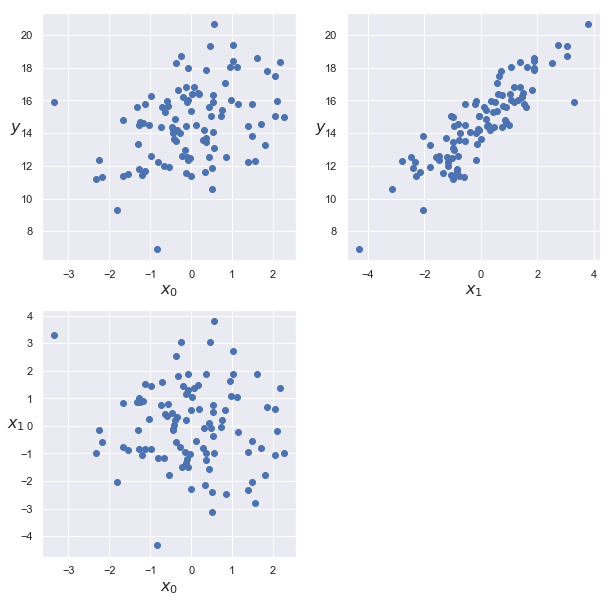

In [5]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)
plt.savefig('B04958_04_25.png', dpi=300, figsize=(5.5, 5.5))

In [4]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000, step=step, start=start, nchains=1)

D:\application\Anaconda3\envs\pymc3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -75.778, ||grad|| = 32.757: 100%|██████████████████████████████████████████████| 41/41 [00:00<00:00, 587.28it/s]
D:\application\Anaconda3\envs\pymc3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\application\Anaconda3\envs

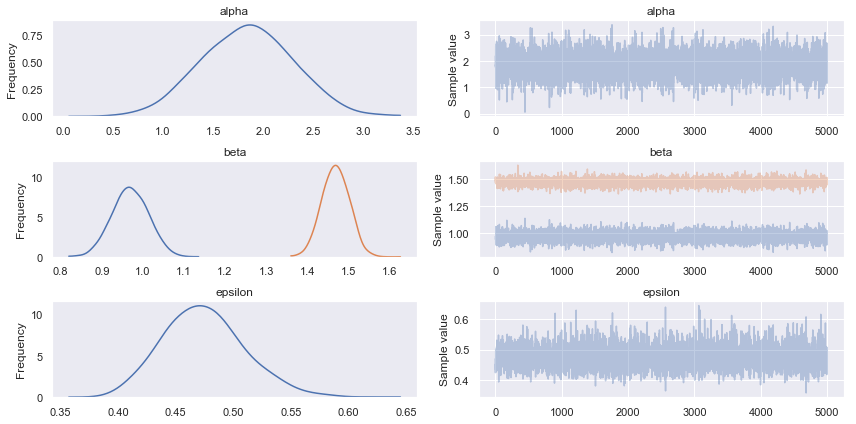

In [5]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames)
plt.savefig('B04958_04_26.png', dpi=300, figsize=(5.5, 5.5));

In [6]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.84,0.46,5.45e-03,0.93,2.69
beta__0,0.97,0.04,5.21e-04,0.88,1.05
beta__1,1.47,0.03,3.32e-04,1.40,1.53
epsilon,0.47,0.04,4.77e-04,0.41,0.54


## 1. Confounding variables and redundant variables

In [6]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

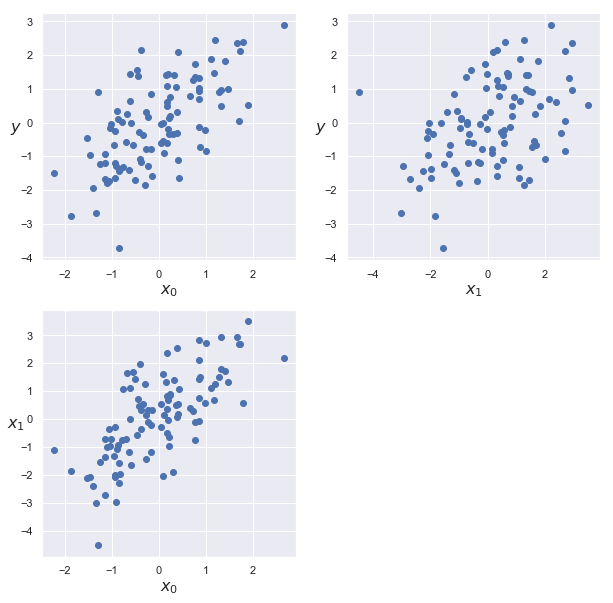

In [7]:
scatter_plot(X, y)
plt.savefig('B04958_04_27.png', dpi=300, figsize=(5.5, 5.5));

In [8]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start, nchains=1)

D:\application\Anaconda3\envs\pymc3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.13, ||grad|| = 0.08875: 100%|█████████████████████████████████████████████| 15/15 [00:00<00:00, 578.50it/s]
D:\application\Anaconda3\envs\pymc3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\application\Anaconda3\envs

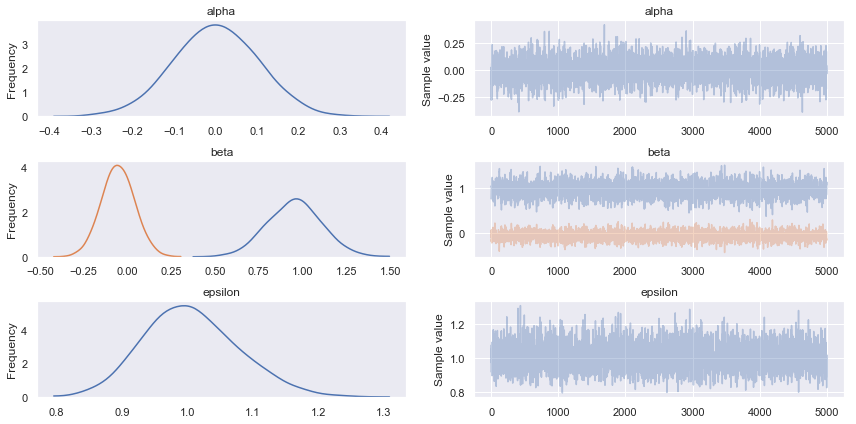

In [18]:
pm.traceplot(trace_red)
plt.savefig('B04958_04_128.png', dpi=300, figsize=(5.5, 5.5))

In [10]:
pm.summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.64e-03,0.10,1.29e-03,-0.19,0.20
beta__0,9.56e-01,0.15,3.40e-03,0.65,1.25
beta__1,-5.29e-02,0.09,2.00e-03,-0.23,0.14
epsilon,1.01e+00,0.07,1.00e-03,0.86,1.15


## 2. Correlation is too high

In [13]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
# 增加了一个很小的扰动，因而两个变量可以看做是一样的
x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

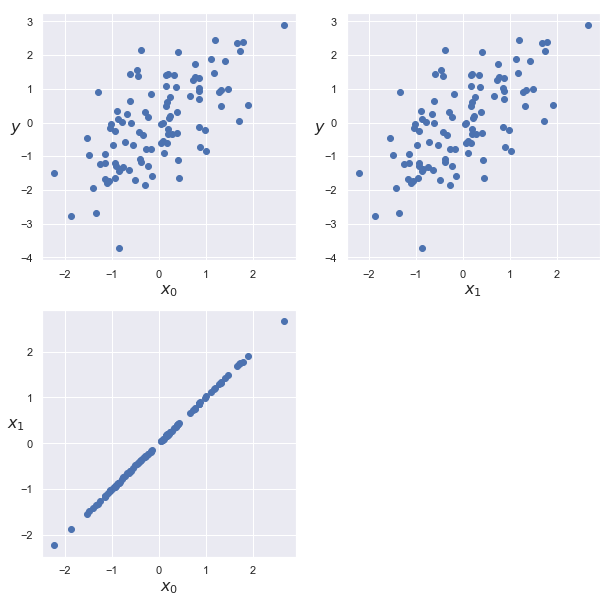

In [14]:
scatter_plot(X, y)
plt.savefig('B04958_04_101.png', dpi=300, figsize=(5.5, 5.5));

In [16]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red_2 = pm.sample(5000, step=step, start=start, nchains=1)

D:\application\Anaconda3\envs\pymc3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.27, ||grad|| = 1.9252: 100%|█████████████████████████████████████████████| 29/29 [00:00<00:00, 1723.48it/s]
D:\application\Anaconda3\envs\pymc3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\application\Anaconda3\envs

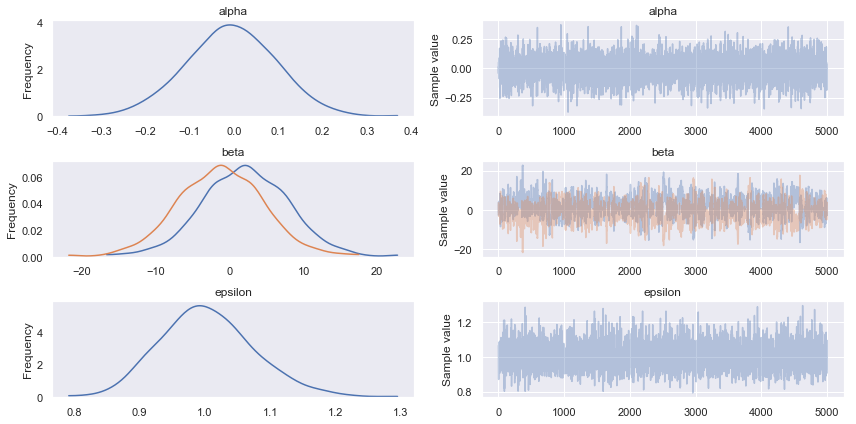

In [19]:
pm.traceplot(trace_red_2)
plt.savefig('B04958_04_102.png', dpi=300, figsize=(5.5, 5.5))

In [20]:
pm.summary(trace_red_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-6.05e-03,0.10,1.56e-03,-0.21,0.19
beta__0,2.13e+00,5.84,2.94e-01,-9.05,14.37
beta__1,-1.24e+00,5.83,2.93e-01,-13.89,9.45
epsilon,1.00e+00,0.07,1.10e-03,0.87,1.15


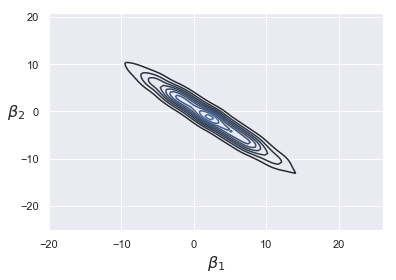

In [23]:
sns.kdeplot(trace_red_2['beta'][:,0], trace_red_2['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)
plt.savefig('B04958_04_29.png', dpi=300, figsize=(5.5, 5.5));

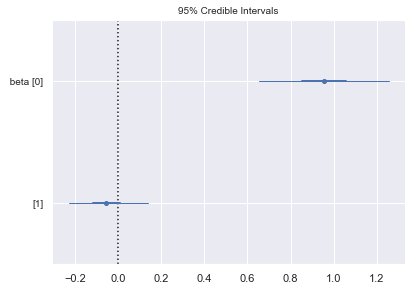

In [24]:
pm.forestplot(trace_red, varnames=['beta'])
plt.savefig('B04958_04_30.png', dpi=300, figsize=(5.5, 5.5))

## 3. Masking effect variables

In [25]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

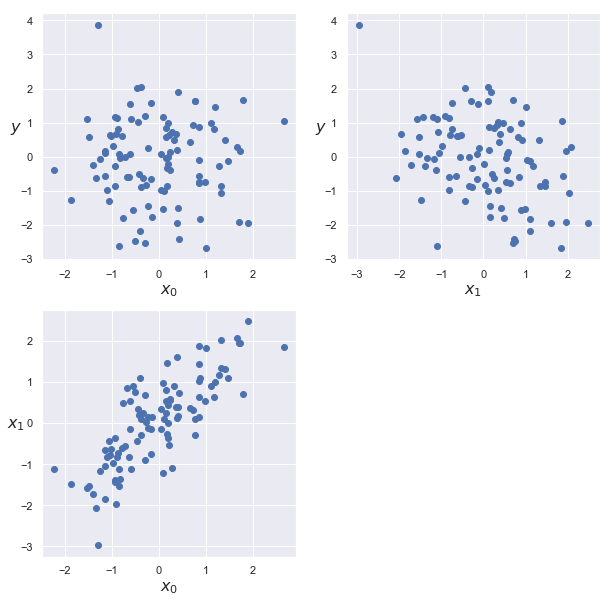

In [26]:
scatter_plot(X, y)
plt.savefig('B04958_04_31.png', dpi=300, figsize=(5.5, 5.5));

In [27]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ma = pm.sample(5000, step=step, start=start, nchains=1)

D:\application\Anaconda3\envs\pymc3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -151.44, ||grad|| = 0.011018: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 1554.89it/s]
D:\application\Anaconda3\envs\pymc3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\application\Anaconda3\envs

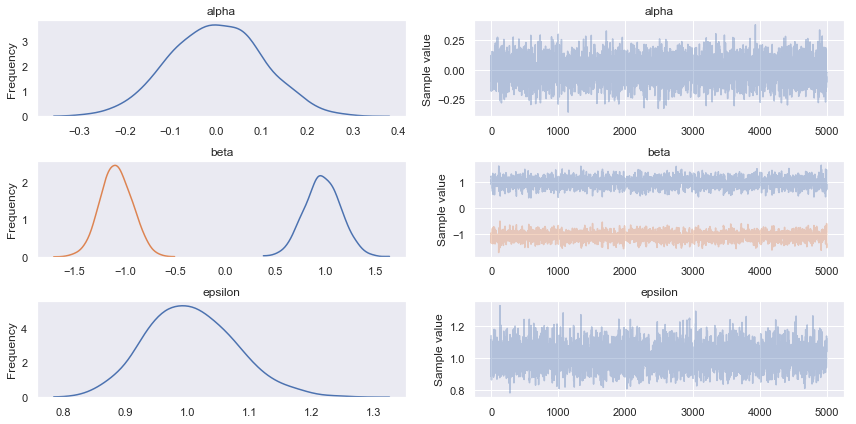

In [28]:
pm.traceplot(trace_ma)
plt.savefig('B04958_04_32.png', dpi=300, figsize=(5.5, 5.5));

In [29]:
pm.summary(trace_ma)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,8.55e-05,0.10,1.30e-03,-0.20,0.19
beta__0,9.74e-01,0.18,4.52e-03,0.64,1.34
beta__1,-1.09e+00,0.16,3.77e-03,-1.39,-0.78
epsilon,1.01e+00,0.07,8.87e-04,0.86,1.14


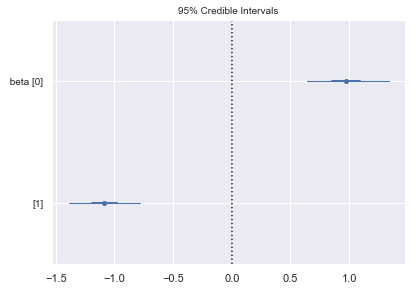

In [30]:
pm.forestplot(trace_ma, varnames=['beta']);
plt.savefig('B04958_04_33.png', dpi=300, figsize=(5.5, 5.5));

In [31]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora AMD64 corriendo   y usando:
Python 3.6.0
IPython 7.8.0
PyMC3 3.6
NumPy 1.15.4
SciPy 1.1.0
Matplotlib 3.0.0
Seaborn 0.9.0

